<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Define-dataset-and-transforms" data-toc-modified-id="Define-dataset-and-transforms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define dataset and transforms</a></span></li></ul></div>

## Load data

In [1]:
from mantisshrimp.all import *
import pandas as pd

In [2]:
source = Path('/home/lgvaz/.data/imaterialist/')

In [3]:
df = pd.read_csv(source/'train.csv', nrows=1000)

In [4]:
df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [5]:
class MaterialInfoParser(ImageParser):
    def __iter__(self): return self.data.itertuples()
    def iid(self, o): return o.ImageId
    def file_path(self, o): return self.source/f'train/{o.ImageId}.jpg'
    def height(self, o): return o.Height
    def width(self, o): return o.Width
    def oid(self, o): return o.ClassId # TODO: AttributeIds

In [6]:
class MaterialAnnotParser(AnnotationParser):
    def __iter__(self): return self.data.itertuples()
    def iid(self, o): return o.ImageId
    def oid(self, o): return o.ClassId
    def seg(self, o): return RLE.from_kaggle(lmap(int, o.EncodedPixels.split(' ')))
    def bbox(self, o):
        rle = self.seg(o)
        return BBox.from_rle(rle, o.Height, o.Width)

In [7]:
labels_descriptions = json.load((source/'label_descriptions.json').open())
cats = [Category(o['id'], o['name']) for o in labels_descriptions['categories']]
catmap = CategoryMap(cats)

In [8]:
parser = DataParser(df, source, catmap, img_parser=MaterialInfoParser, annot_parser=MaterialAnnotParser)
rtrain, rvalid = parser.parse()


Removed 0 images that don't have annotations


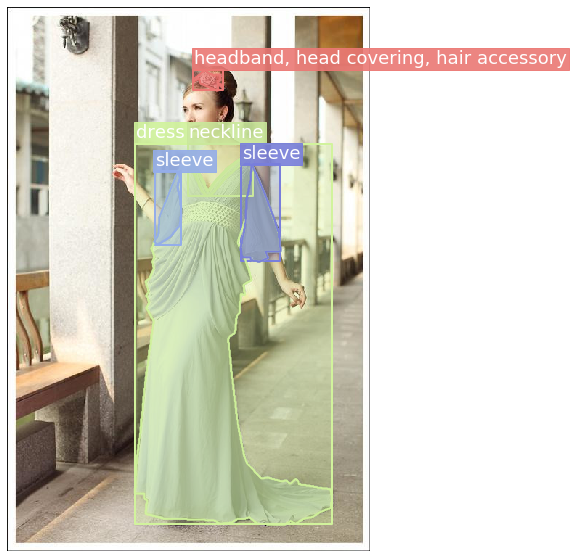

In [9]:
show_record(rtrain[4], catmap=catmap, bbox=True)

## Define dataset and transforms

In [10]:
train_tfms = AlbumentationTransformer([A.LongestMaxSize(512), A.HorizontalFlip()])
valid_tfms = AlbumentationTransformer([A.LongestMaxSize(512)])

In [11]:
train_ds = Dataset(rtrain, )
train_dl = RCNNDataloader(train_ds, batch_size=2, shuffle=True, num_workers=8)

NameError: name 'tfms' is not defined

In [ ]:
valid_ds = Dataset(rvalid, valid_tfms)
valid_dl = RCNNDataloader(valid_ds, batch_size=2, num_workers=8)

In [ ]:
model = MaskRCNNModel(len(catmap))

In [ ]:
trainer = Trainer(max_epochs=2, gpus=1)

In [17]:
trainer.fit(model, train_dl, valid_dl)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 44 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


RuntimeError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 7.93 GiB total capacity; 6.17 GiB already allocated; 46.88 MiB free; 6.76 GiB reserved in total by PyTorch)